# Задание 3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pmdarima as pm
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV , StratifiedKFold
from sklearn.linear_model import LassoCV, RidgeCV
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from prophet import Prophet
%matplotlib inline

#pip install meteostat
from datetime import datetime
from meteostat import Stations, Point, Daily

import warnings
warnings.filterwarnings("ignore")

In [2]:
wind = pd.read_csv('data/data.csv')
wind.head()

dt      MW
0  2011-01-01 00:00:00  3416.0
1  2011-01-01 00:15:00  4755.0
2  2011-01-01 00:30:00  4939.0
3  2011-01-01 00:45:00  4939.0
4  2011-01-01 01:00:00  4998.0

Убедимся, что нет пропущенных значений:

In [3]:
wind.isnull().sum()

dt    0
MW    0
dtype: int64

In [4]:
wind.isna().sum()

dt    0
MW    0
dtype: int64

In [5]:
wind['dt'] = pd.to_datetime(wind['dt'])

In [6]:
print(f'Временной промежуток датасета: {wind.dt.min()} –– {wind.dt.max()}')

Временной промежуток датасета: 2011-01-01 00:00:00 –– 2021-12-30 07:45:00


### Анализ временного ряда

 Посмотрим на основные статистики временного ряда:

In [7]:
wind.describe()

MW
count  385566.000000
mean     3183.560481
std      3045.941591
min         0.000000
25%       905.000000
50%      2164.000000
75%      4529.877500
max     16727.500000

In [8]:
print(f'Максимальные показатели по произведенной энергии: \n{wind.loc[wind.MW==wind.MW.max()]}')

Максимальные показатели по произведенной энергии: 
                        dt       MW
378846 2021-10-21 09:00:00  16727.5


Сгенерируем дополнительные признаки для удобства последующего анализа и прогнозирования:

In [9]:
wind['year'] = wind['dt'].dt.year
wind['month'] = wind['dt'].dt.month
wind['weekday'] = wind['dt'].dt.weekday #Monday=0, Sunday=6
wind['hour'] = wind['dt'].dt.strftime('%H')

wind.head(15)

dt      MW  year  month  weekday hour
0  2011-01-01 00:00:00  3416.0  2011      1        5   00
1  2011-01-01 00:15:00  4755.0  2011      1        5   00
2  2011-01-01 00:30:00  4939.0  2011      1        5   00
3  2011-01-01 00:45:00  4939.0  2011      1        5   00
4  2011-01-01 01:00:00  4998.0  2011      1        5   01
5  2011-01-01 01:15:00  5184.0  2011      1        5   01
6  2011-01-01 01:30:00  5341.0  2011      1        5   01
7  2011-01-01 01:45:00  5438.0  2011      1        5   01
8  2011-01-01 02:00:00  5509.0  2011      1        5   02
9  2011-01-01 02:15:00  5638.0  2011      1        5   02
10 2011-01-01 02:30:00  5582.0  2011      1        5   02
11 2011-01-01 02:45:00  5792.0  2011      1        5   02
12 2011-01-01 03:00:00  5962.0  2011      1        5   03
13 2011-01-01 03:15:00  6009.0  2011      1        5   03
14 2011-01-01 03:30:00  6025.0  2011      1        5   03

Для начала посмотрим на графики временного ряда по часам, месяцам и годам: 

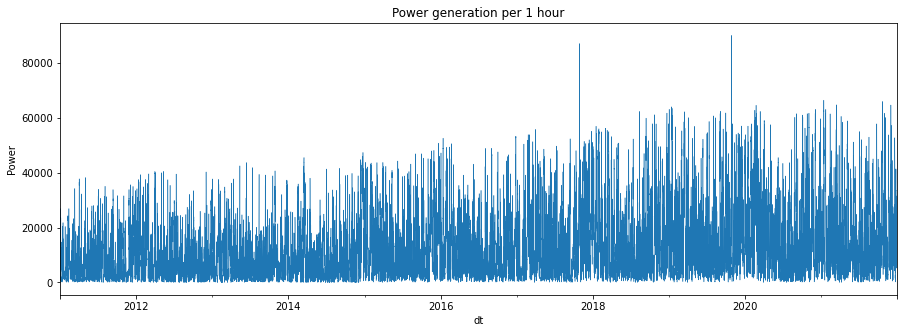

In [10]:
hour_df = (wind.set_index('dt')).resample('H')['MW'].sum()
plt.figure(figsize = (15,5))
hour_df.plot(kind='line',linewidth=0.5)
plt.ylabel('Power')
plt.title('Power generation per 1 hour')
plt.show()

На графике по количеству энергии, сгруппированной по часам, видно, что есть тренд по увеличению выработки энергии, а также в конце 2017 и 2019 годов было очень резкое увеличение в производстве энергии.

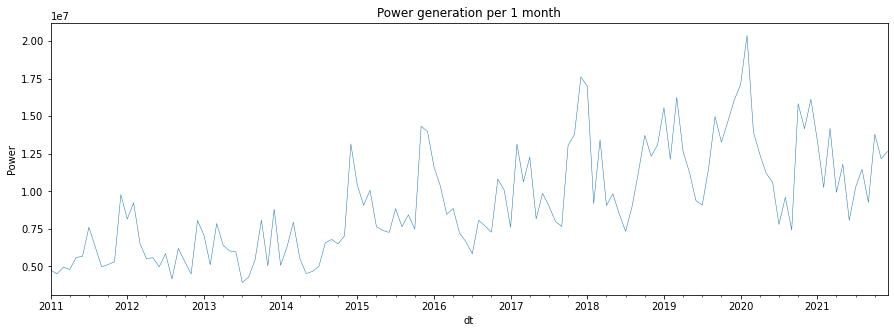

In [11]:
month_df = (wind.set_index('dt')).resample('M')['MW'].sum()
plt.figure(figsize = (15,5))
month_df.plot(kind='line',linewidth=0.5)
plt.ylabel('Power')
plt.title('Power generation per 1 month')
plt.show()

В графике, сгруппированном по месяцу, виден не только тренд увеличения, но и некоторая сезонность.

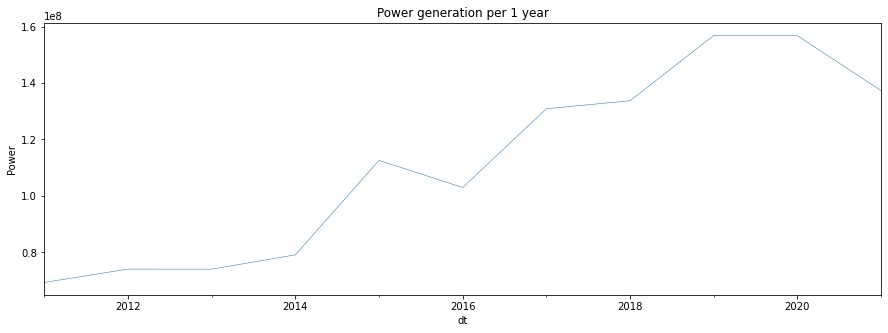

In [12]:
year_df = (wind.set_index('dt')).resample('Y')['MW'].sum()
plt.figure(figsize = (15,5))
year_df.plot(kind='line',linewidth=0.5)
plt.ylabel('Power')
plt.title('Power generation per 1 year')
plt.show()

И, наконец, в ежегодном графике явно видно, что выработка энергии с каждым годом увеличивается. 

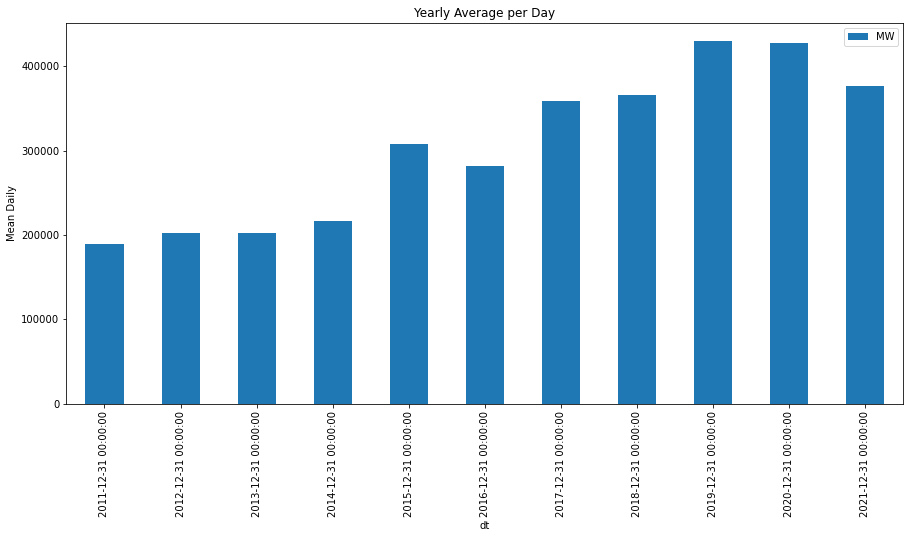

In [13]:
mean_day = pd.DataFrame(wind.set_index('dt').resample('1D')['MW'].sum()).resample('1Y').mean()
mean_day.plot.bar(figsize = (15,7))
plt.title("Yearly Average per Day")
plt.ylabel("Mean Daily")
plt.show()

Среднедневное производство энергии также увеличивается с каждым годом.

Поскольку из вышевыведенных графиков на первый взгляд наиболее явно виден тренд и сезонность в графике, сгруппированном  по месяцам, попробуем разложить на компоненты и убедиться в предположении:  

In [14]:
def decompose(df, df_name):
    dec = seasonal_decompose(df, model = 'additive', extrapolate_trend='freq')
    plt.rcParams.update({'figure.figsize': (20, 10)})
    dec.plot().suptitle(f'{df_name} Decompose', y = 1.05, fontsize=30)
    plt.show() 
    return 

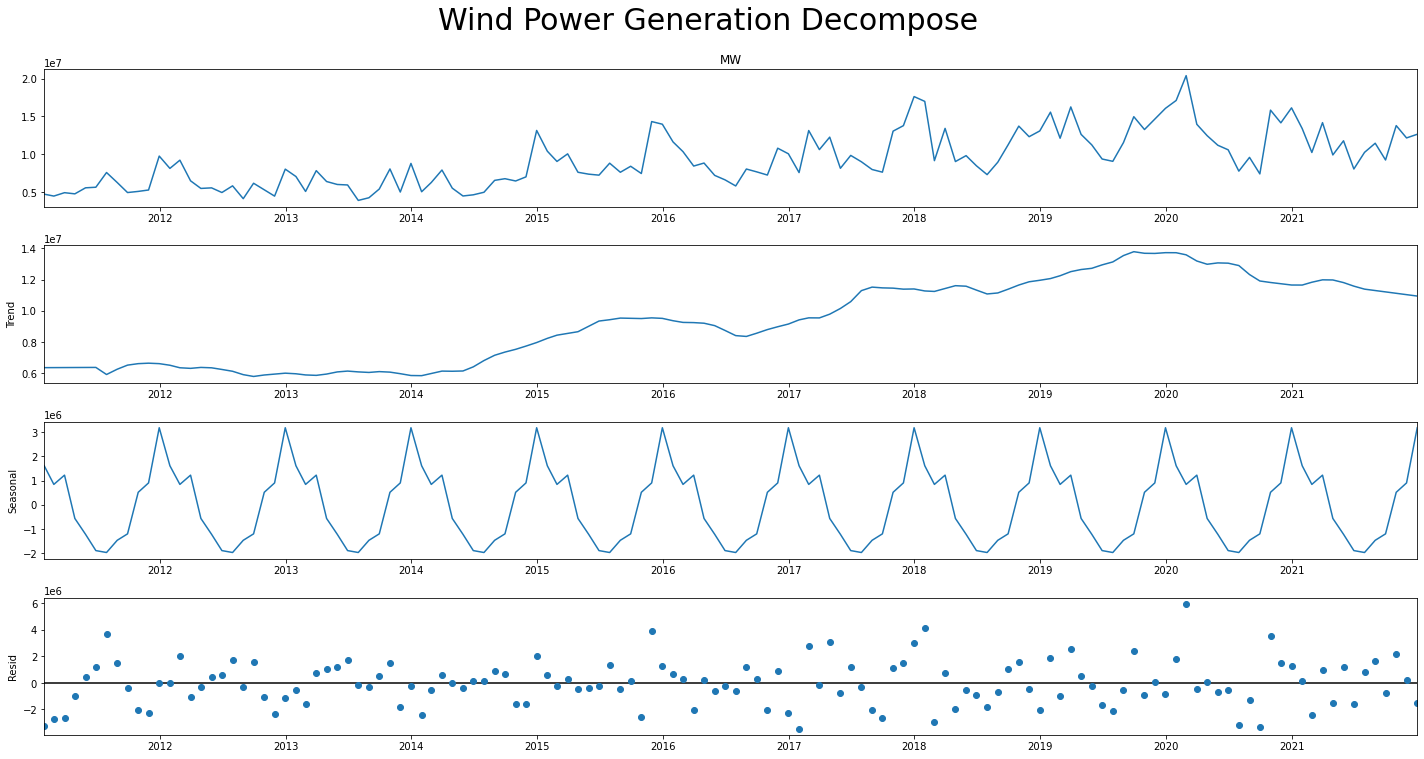

In [15]:
decompose(month_df, 'Wind Power Generation')

Действительно, в наших данных есть явный тренд и сезонность. 

Посмотрим еще, есть ли какой-то паттерн в данных по часам (может в какой-то момент времени в днем генерируется наибольшее количество энергии?) и данных по неделям (например, производится ли энергия в выходные? или может в какой-то день недели станции работают на наибольшую мощность?) :

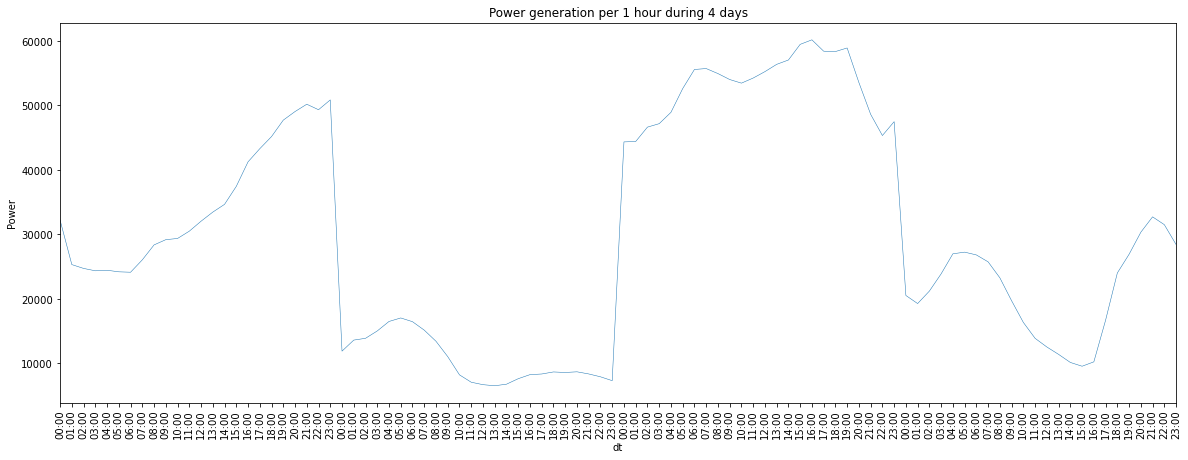

In [16]:
plt.figure(figsize = (20,7))
hour_df['2021-11-01 00:00:00':'2021-11-04 23:00:00'].plot(kind='line',linewidth=0.5)
plt.ylabel('Power')
plt.xticks(hour_df['2021-11-01 00:00:00':'2021-11-04 23:00:00'].index, hour_df['2021-11-01 00:00:00':'2021-11-04 23:00:00'].index.strftime('%H:%M'),rotation = 90)
plt.title('Power generation per 1 hour during 4 days')
plt.show()

Из анализа нескольких дней видно, что наибольшее количество энергии вырабатывается примерно в промежуток 17.00-22.00, затем резко падает до следующего рабочего дня.

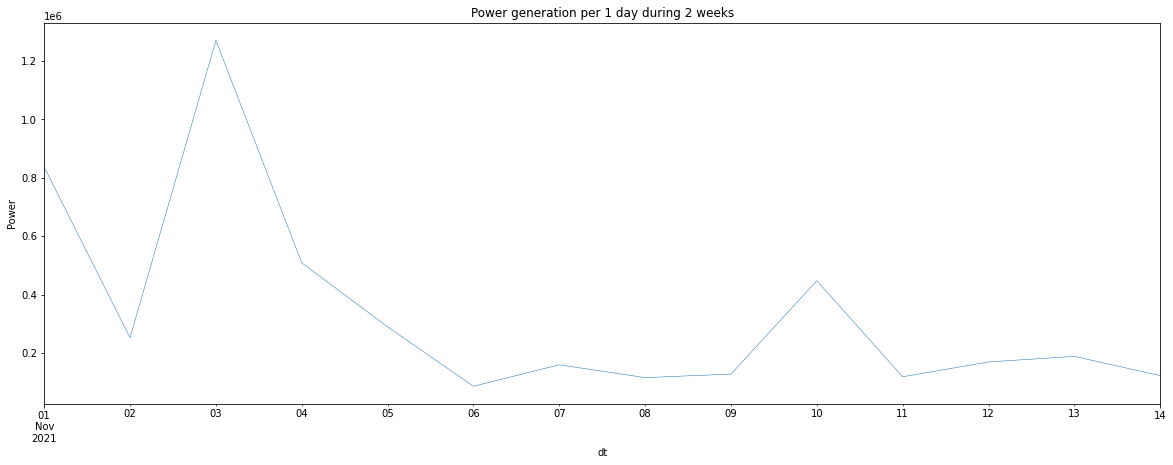

In [17]:
day_df = (wind.set_index('dt')).resample('1d')['MW'].sum()

plt.figure(figsize = (20,7))
day_df['2021-11-01':'2021-11-14'].plot(kind='line',linewidth=0.5)
plt.ylabel('Power')
plt.title('Power generation per 1 day during 2 weeks')
plt.show()

На графике за две недели видно, что наибольшая производительность приходится на среду, а к выходным количество энергии падает. 

In [18]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Проанализируем стационарность временного ряда с частотой 1 месяц. На первый взгляд кажется, что он не стационарен. Но убедимся в этом при помощи теста Дики Фулера:

Results of Dickey-Fuller Test:
Test Statistic                  -1.395004
p-value                          0.584669
#Lags Used                       9.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


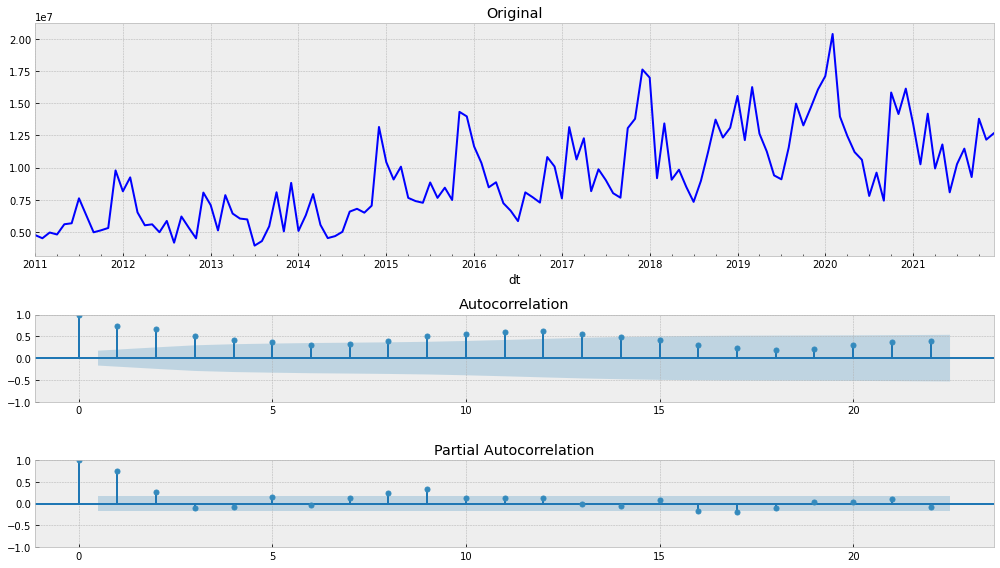

In [19]:
tsplot(month_df)

Из p-value и графиков видно, что тест Дики-Фулера не отвергает гипотезу о нестационарности временного ряда. Попробуем убрать размах дисперсии при помощи преобразования Бокса-Кокса:

Results of Dickey-Fuller Test:
Test Statistic                  -0.966711
p-value                          0.765211
#Lags Used                      11.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


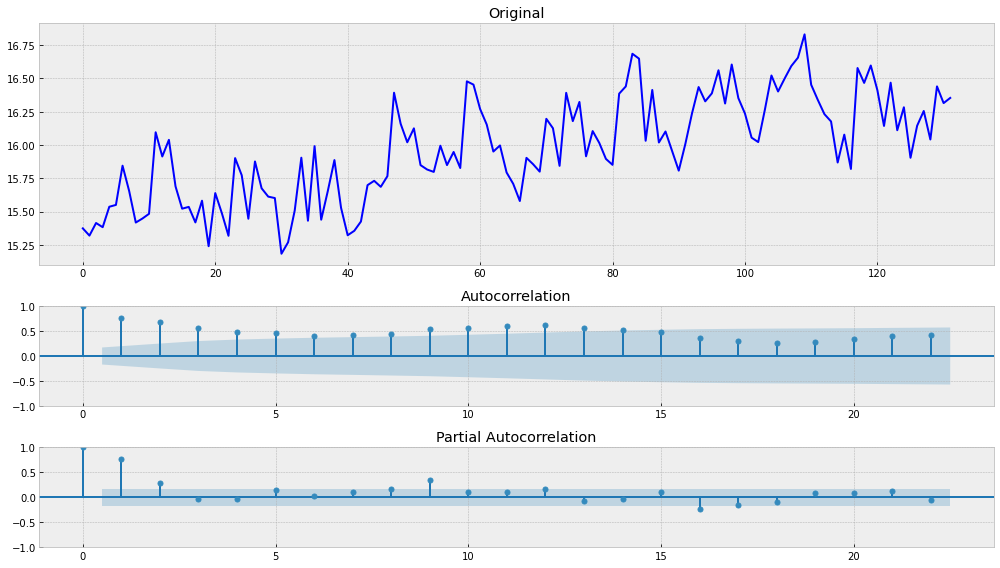

In [20]:
wind_transform = boxcox(month_df, 0)
tsplot(wind_transform)

Из p-value и графиков видно, что тест Дики-Фулера снова не отвергает гипотезу о нестационарности временного ряда. Попробуем воспользоваться дифференцированием, чтобы убрать тренд:

Results of Dickey-Fuller Test:
Test Statistic                -6.951613e+00
p-value                        9.660295e-10
#Lags Used                     1.000000e+01
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64


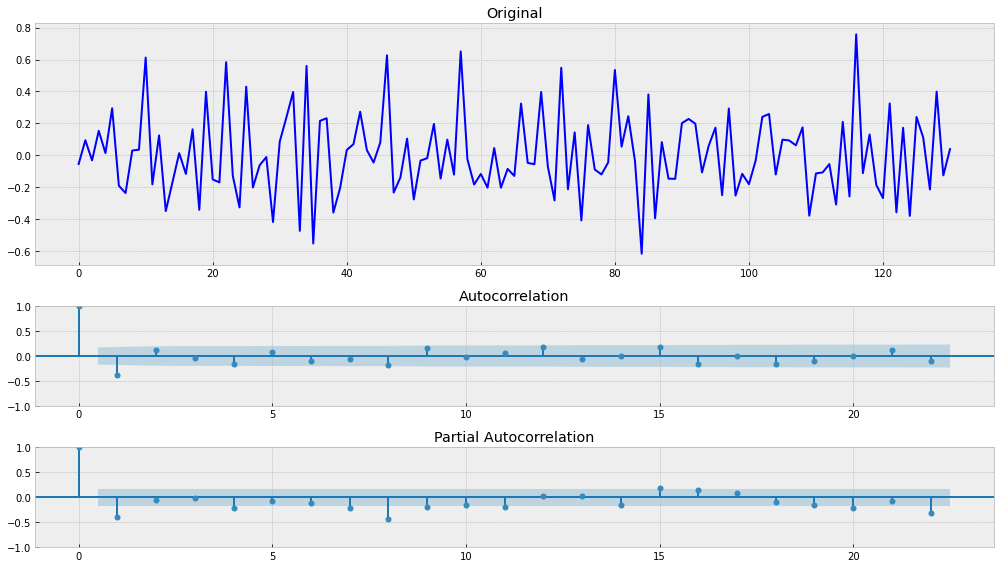

In [21]:
wind_transform = wind_transform[1:] - wind_transform[:-1]
tsplot(wind_transform)

Попробуем еще немного убрать сезонность:

Results of Dickey-Fuller Test:
Test Statistic                  -4.217972
p-value                          0.000614
#Lags Used                      13.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


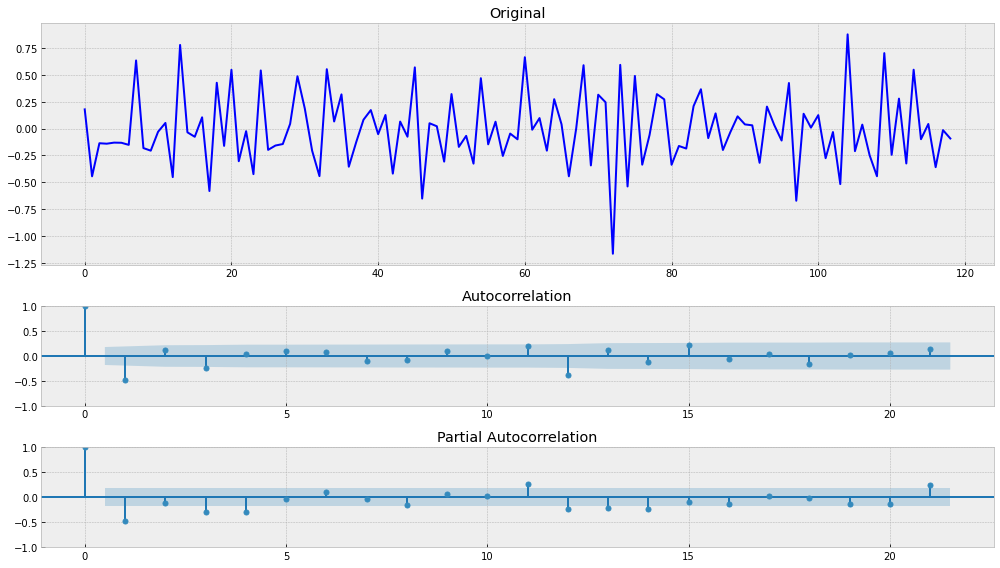

In [22]:
wind_transform = wind_transform[12:] - wind_transform[:-12]
tsplot(wind_transform)

Теперь p-value меньше 0,05, можем сделать вывод, что удалось добиться стационарности временного ряда.

### Feature Engineering

In [23]:
wind.head()

dt      MW  year  month  weekday hour
0 2011-01-01 00:00:00  3416.0  2011      1        5   00
1 2011-01-01 00:15:00  4755.0  2011      1        5   00
2 2011-01-01 00:30:00  4939.0  2011      1        5   00
3 2011-01-01 00:45:00  4939.0  2011      1        5   00
4 2011-01-01 01:00:00  4998.0  2011      1        5   01

По выводам, сделанным выше, можно предположить, что прогноз модели можно улучшить, если добавить выявленные паттерны: часть суток, день недели (в том числе, является ли  день недели выходным). Сделаем необходимые преобразования:

In [24]:
wind['Dawn'] = ((wind['dt'].dt.hour<=6) &  (wind['dt'].dt.hour>=0) ).astype(int)
wind['Morning'] = ((wind['dt'].dt.hour>6) &  (wind['dt'].dt.hour<=12) ).astype(int)
wind['Afternoon'] = ((wind['dt'].dt.hour>12) &  (wind['dt'].dt.hour<=16) ).astype(int)
wind['Night'] = (wind['dt'].dt.hour>17).astype(int)
wind['Weekend'] = ((wind['weekday'] == 5) | (wind['weekday'] == 6)).astype(int)

wind.head()

dt      MW  year  month  weekday hour  Dawn  Morning  \
0 2011-01-01 00:00:00  3416.0  2011      1        5   00     1        0   
1 2011-01-01 00:15:00  4755.0  2011      1        5   00     1        0   
2 2011-01-01 00:30:00  4939.0  2011      1        5   00     1        0   
3 2011-01-01 00:45:00  4939.0  2011      1        5   00     1        0   
4 2011-01-01 01:00:00  4998.0  2011      1        5   01     1        0   

   Afternoon  Night  Weekend  
0          0      0        1  
1          0      0        1  
2          0      0        1  
3          0      0        1  
4          0      0        1

Добавим в датасет лаги: 

In [25]:
wind_lags = wind.copy()

for x in [1,12,24,48,72]:
    wind_lags[f'lag_{x}'] = wind.MW.shift(x).bfill()

wind_lags.head()

dt      MW  year  month  weekday hour  Dawn  Morning  \
0 2011-01-01 00:00:00  3416.0  2011      1        5   00     1        0   
1 2011-01-01 00:15:00  4755.0  2011      1        5   00     1        0   
2 2011-01-01 00:30:00  4939.0  2011      1        5   00     1        0   
3 2011-01-01 00:45:00  4939.0  2011      1        5   00     1        0   
4 2011-01-01 01:00:00  4998.0  2011      1        5   01     1        0   

   Afternoon  Night  Weekend   lag_1  lag_12  lag_24  lag_48  lag_72  
0          0      0        1  3416.0  3416.0  3416.0  3416.0  3416.0  
1          0      0        1  3416.0  3416.0  3416.0  3416.0  3416.0  
2          0      0        1  4755.0  3416.0  3416.0  3416.0  3416.0  
3          0      0        1  4939.0  3416.0  3416.0  3416.0  3416.0  
4          0      0        1  4939.0  3416.0  3416.0  3416.0  3416.0

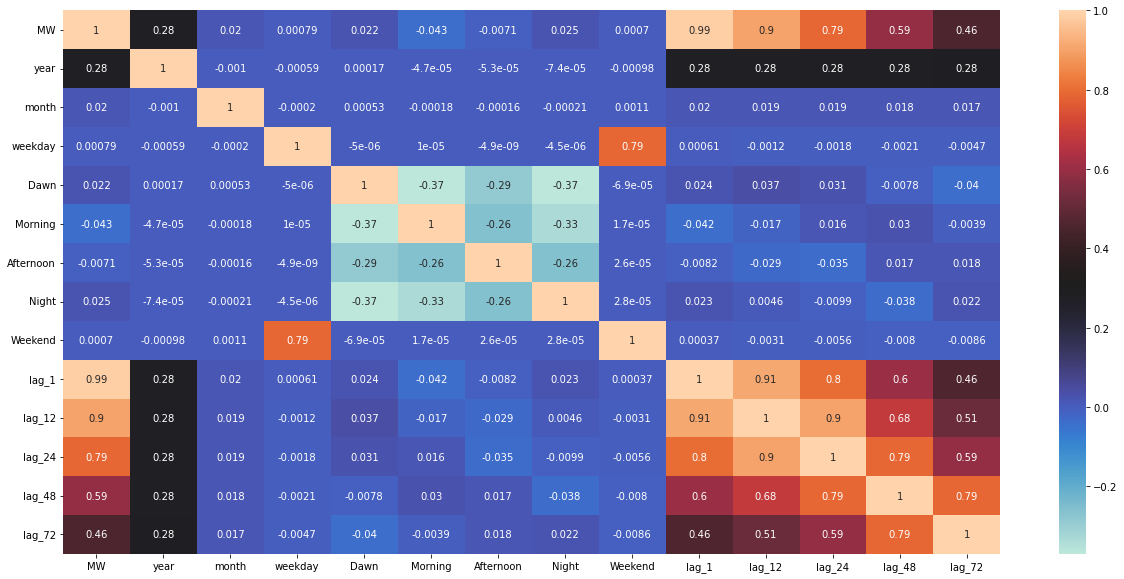

In [26]:
cor = wind_lags.corr()
fig,axes = plt.subplots(1,1,figsize=(21,10))
sns.heatmap(cor,annot=True, cmap ='icefire')
plt.show()

По матрице корреляции видна корреляция между целевой переменной и некоторыми из параметров (лаги, год, раннее утро).

In [27]:
wind_lags = wind_lags.set_index('dt')
wind_lags.head()

MW  year  month  weekday hour  Dawn  Morning  \
dt                                                                      
2011-01-01 00:00:00  3416.0  2011      1        5   00     1        0   
2011-01-01 00:15:00  4755.0  2011      1        5   00     1        0   
2011-01-01 00:30:00  4939.0  2011      1        5   00     1        0   
2011-01-01 00:45:00  4939.0  2011      1        5   00     1        0   
2011-01-01 01:00:00  4998.0  2011      1        5   01     1        0   

                     Afternoon  Night  Weekend   lag_1  lag_12  lag_24  \
dt                                                                       
2011-01-01 00:00:00          0      0        1  3416.0  3416.0  3416.0   
2011-01-01 00:15:00          0      0        1  3416.0  3416.0  3416.0   
2011-01-01 00:30:00          0      0        1  4755.0  3416.0  3416.0   
2011-01-01 00:45:00          0      0        1  4939.0  3416.0  3416.0   
2011-01-01 01:00:00          0      0        1  4939.0  3416.0  3416.0   

                     lag_48  lag_72  
dt                                   
2011-01-01 00:00:00  3416.0  3416.0  
2011-01-01 00:15:00  3416.0  3416.0  
2011-01-01 00:30:00  3416.0  3416.0  
2011-01-01 00:45:00  3416.0  3416.0  
2011-01-01 01:00:00  3416.0  3416.0

In [28]:
train_lag = pd.DataFrame(wind_lags.loc[:'2020-12-31 23:45:00'])
test_lag = pd.DataFrame(wind_lags.loc['2021-01-01 00:00:00':])
print('Train shape: ',train_lag.shape,'. Test shape: ',test_lag.shape)

Train shape:  (350686, 15) . Test shape:  (34880, 15)


In [29]:
X_train_lag = train_lag.drop('MW',1)
X_test_lag = test_lag.drop('MW',1)
y_train_lag = train_lag['MW']
y_test_lag = test_lag['MW']

print('X Train shape: ',X_train_lag.shape,'. X Test shape: ',X_test_lag.shape)
print('Y Train shape: ',y_train_lag.shape,'. Y Test shape: ',y_test_lag.shape)

X Train shape:  (350686, 14) . X Test shape:  (34880, 14)
Y Train shape:  (350686,) . Y Test shape:  (34880,)


Поскольку в прогнозной моделе хочется учесть все новые признаки, а не только значение самого временного ряда, то будем использовать стандартные методы машинного обучения, а именно Линейную регрессию, Лассо регрессию и CatBoost.

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotModelResults(model, X_train, y_train, X_test, y_test):

    train_prediction = model.predict(X_train)
    
    plt.figure(figsize=(20, 10))
    
    plt.plot(y_train, color = 'blue', label='Training data',linewidth=1)
    plt.plot(y_train.index,train_prediction, color = 'orange', label='Predicted train data',linewidth=1)
    
    train_error = mean_absolute_percentage_error(train_prediction, y_train)
    plt.title("Train MAPE {0:.2f}%".format(train_error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    plt.show();
    
    test_prediction = model.predict(X_test)
    
    plt.figure(figsize=(20, 10))
    
    plt.plot(y_test, color = 'red', label='Test data',linewidth=1)
    plt.plot(y_test.index,test_prediction, color = 'green', label='Predicted test data',linewidth=1)
    
    test_error = mean_absolute_percentage_error(test_prediction, y_test)
    plt.title("Test MAPE {0:.2f}%".format(test_error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    plt.show();    
    
def plotCoefficients(model, X_train):

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [31]:
scaler = StandardScaler()

X_train_lag_scaled = scaler.fit_transform(X_train_lag)
X_test_lag_scaled = scaler.transform(X_test_lag)

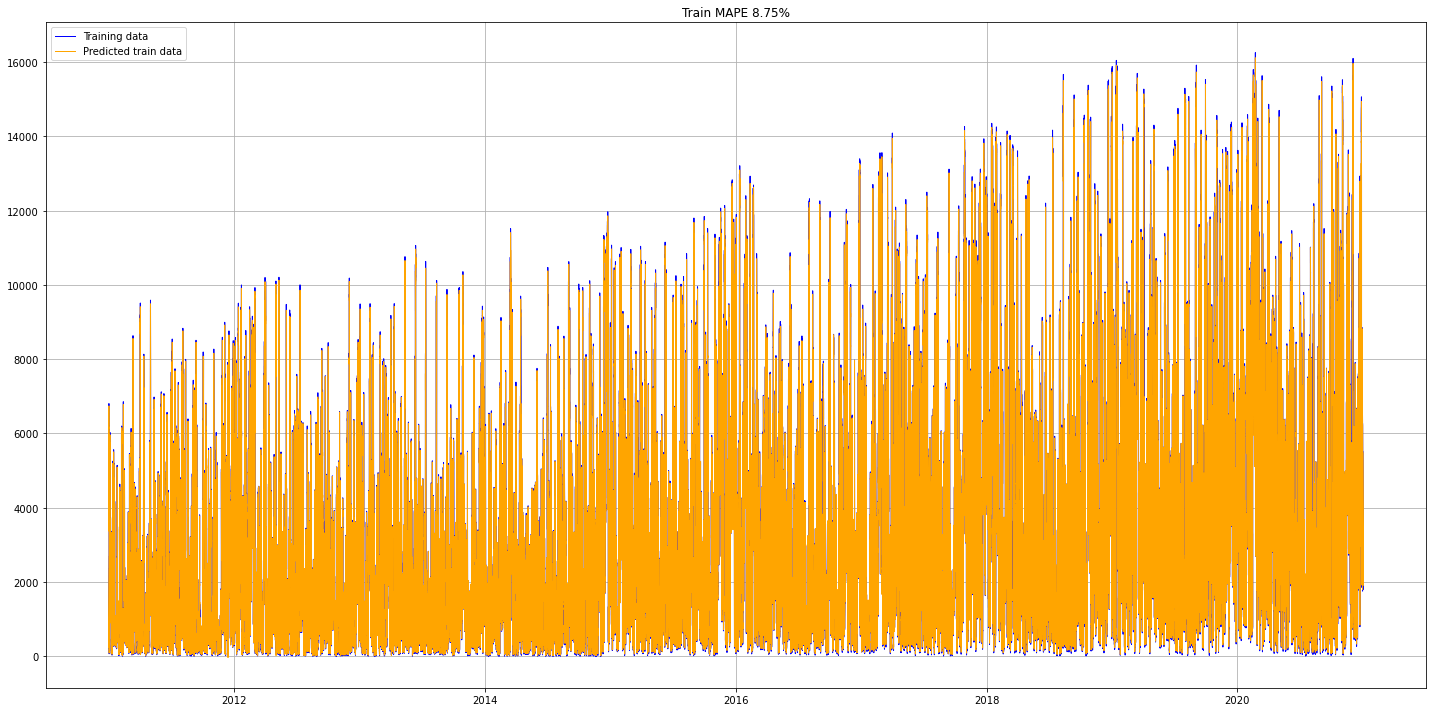

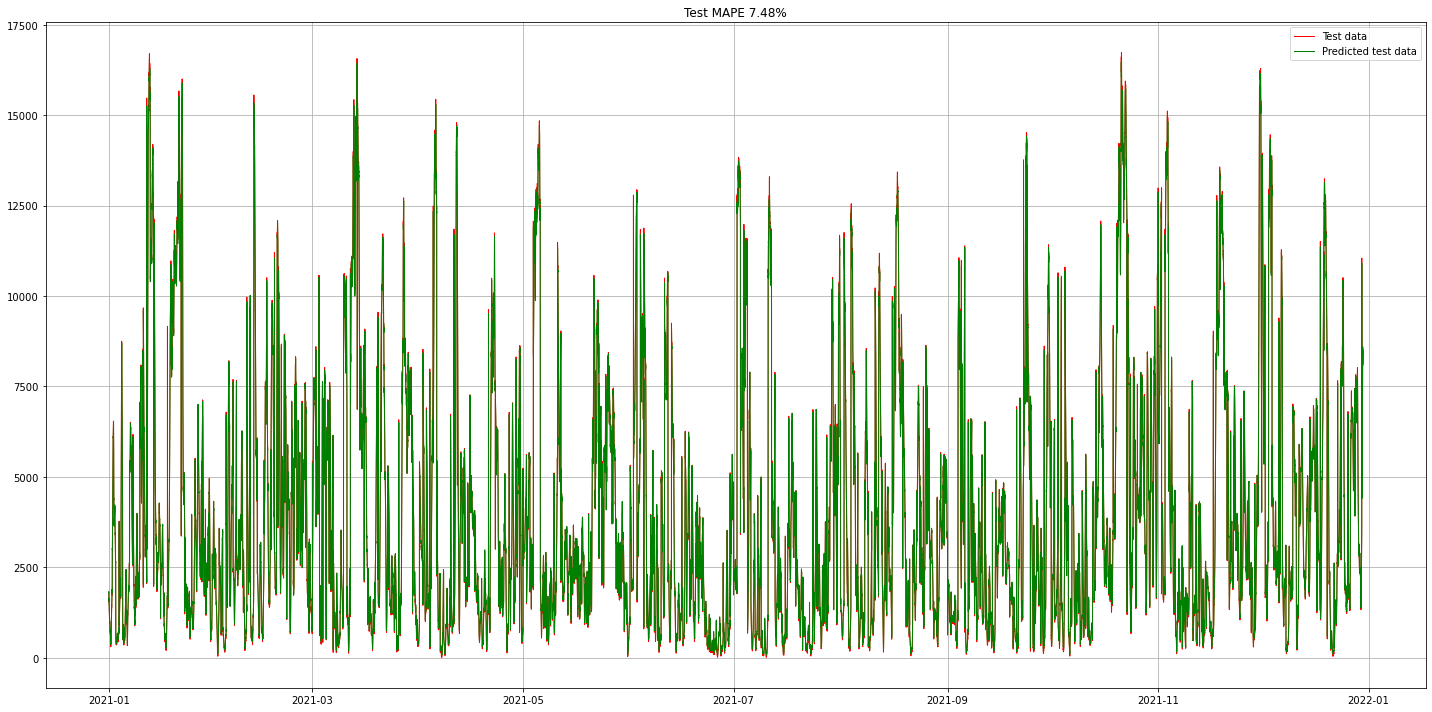

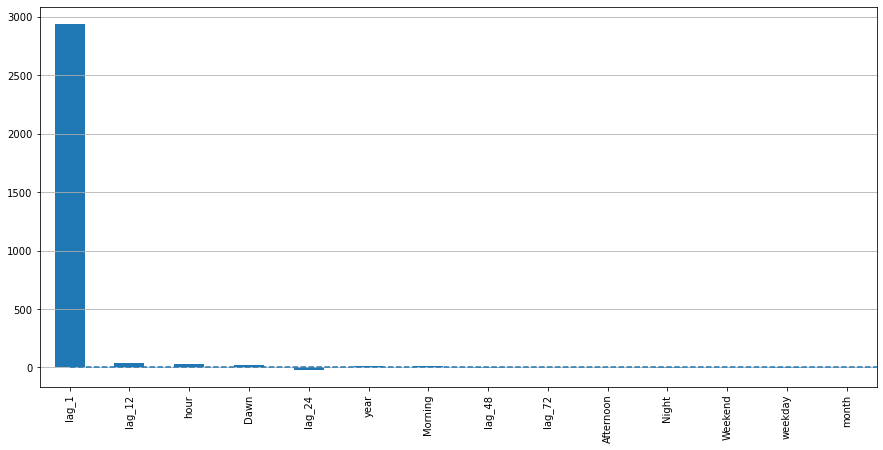

In [32]:
lr_lag = LinearRegression()
lr_lag.fit(X_train_lag_scaled, y_train_lag)

plotModelResults(lr_lag, X_train_lag_scaled, y_train_lag, X_test_lag_scaled, y_test_lag)

plotCoefficients(lr_lag,X_train_lag)

Линейная регрессия достаточно хорошо прогнозирует, показатель метрики тоже достаточно хороший. На модель в большей степени оказывает влияние лаг со сдвигом 1, 12 и 24, время дня, год, а также раннее утро и утро.

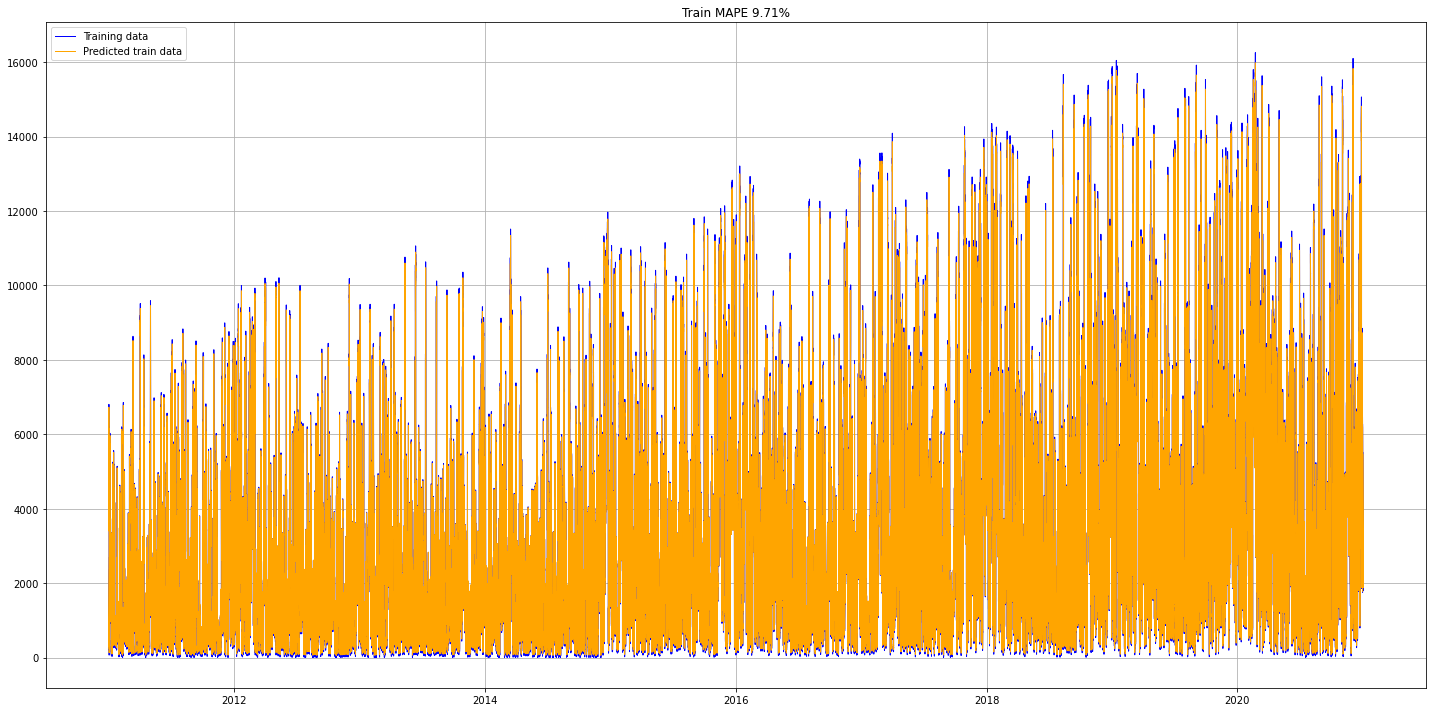

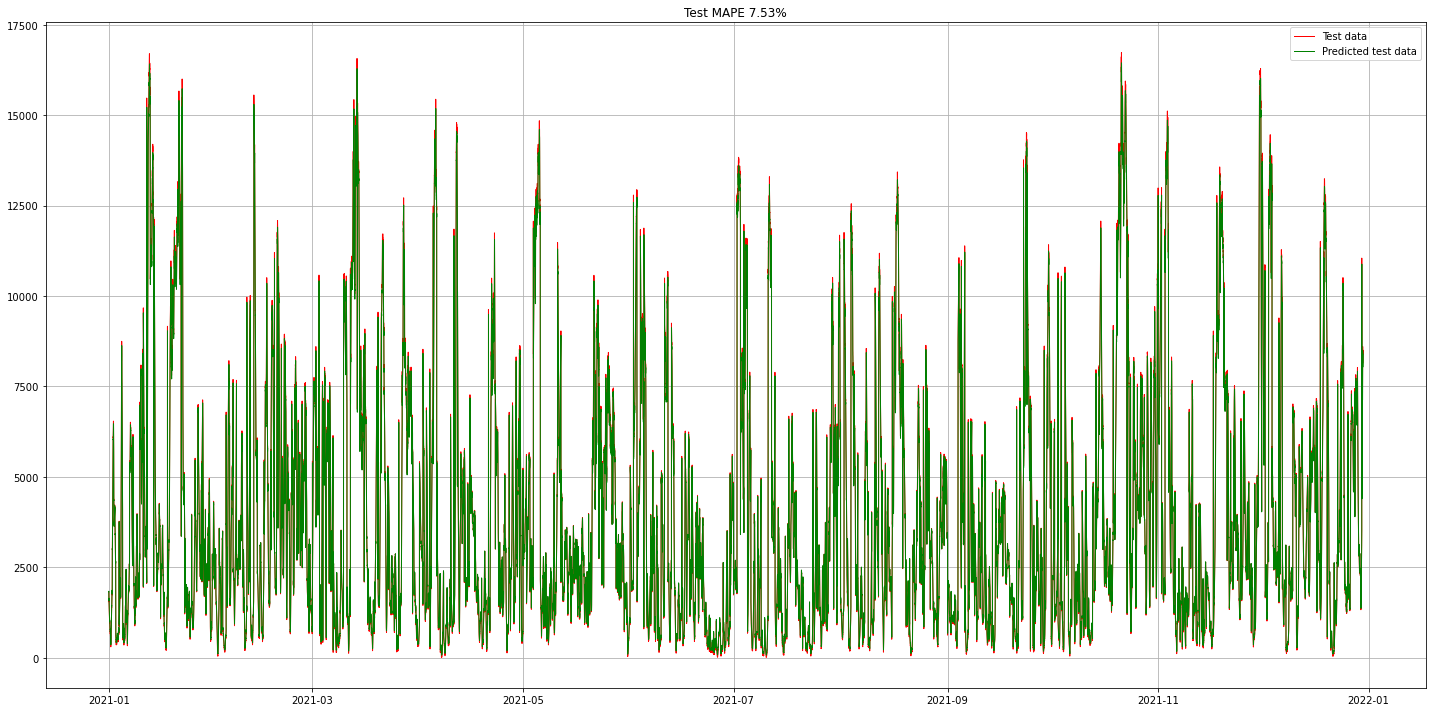

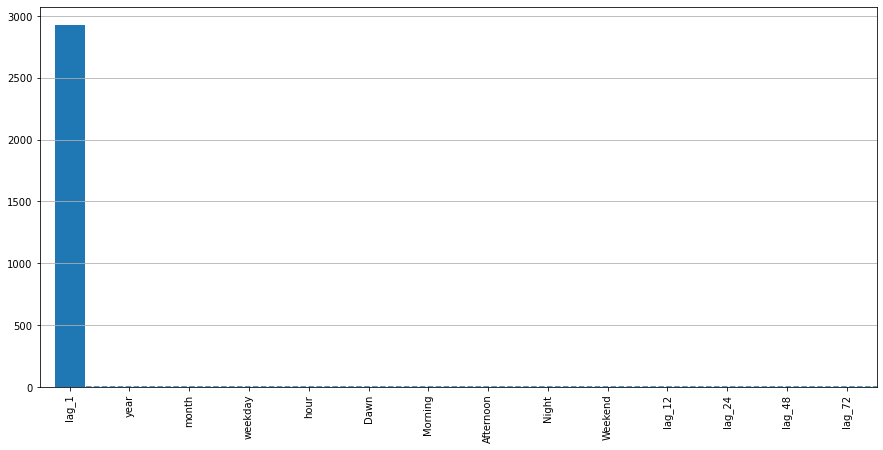

In [33]:
tscv = TimeSeriesSplit(n_splits=5)

lasso_lag = LassoCV(cv=tscv, eps=0.01)
lasso_lag.fit(X_train_lag_scaled, y_train_lag)

plotModelResults(lasso_lag, X_train_lag_scaled, y_train_lag, X_test_lag_scaled, y_test_lag)

plotCoefficients(lasso_lag,X_train_lag)

Лассо регрессия прогнозирует немного хуже, чем линейная. На модель в большей степени оказывает влияние лаг со сдвигом 1.

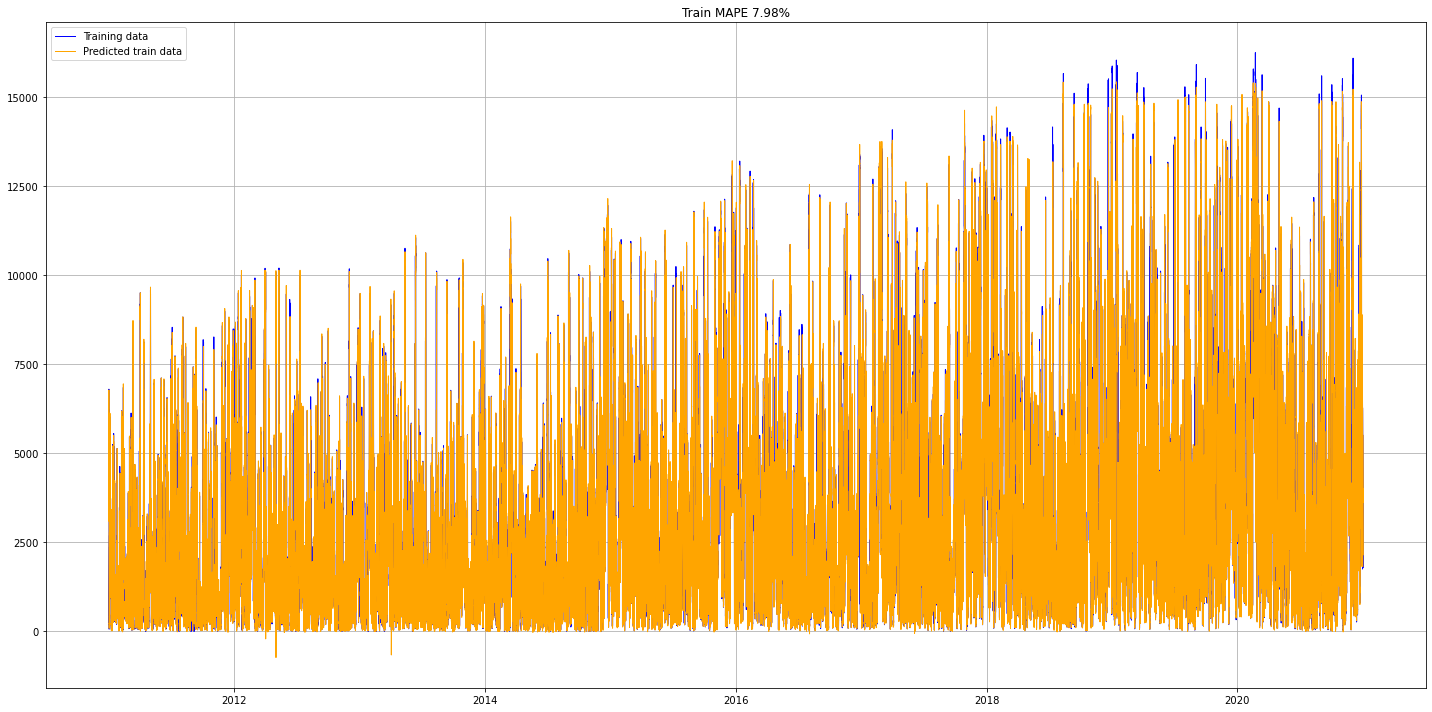

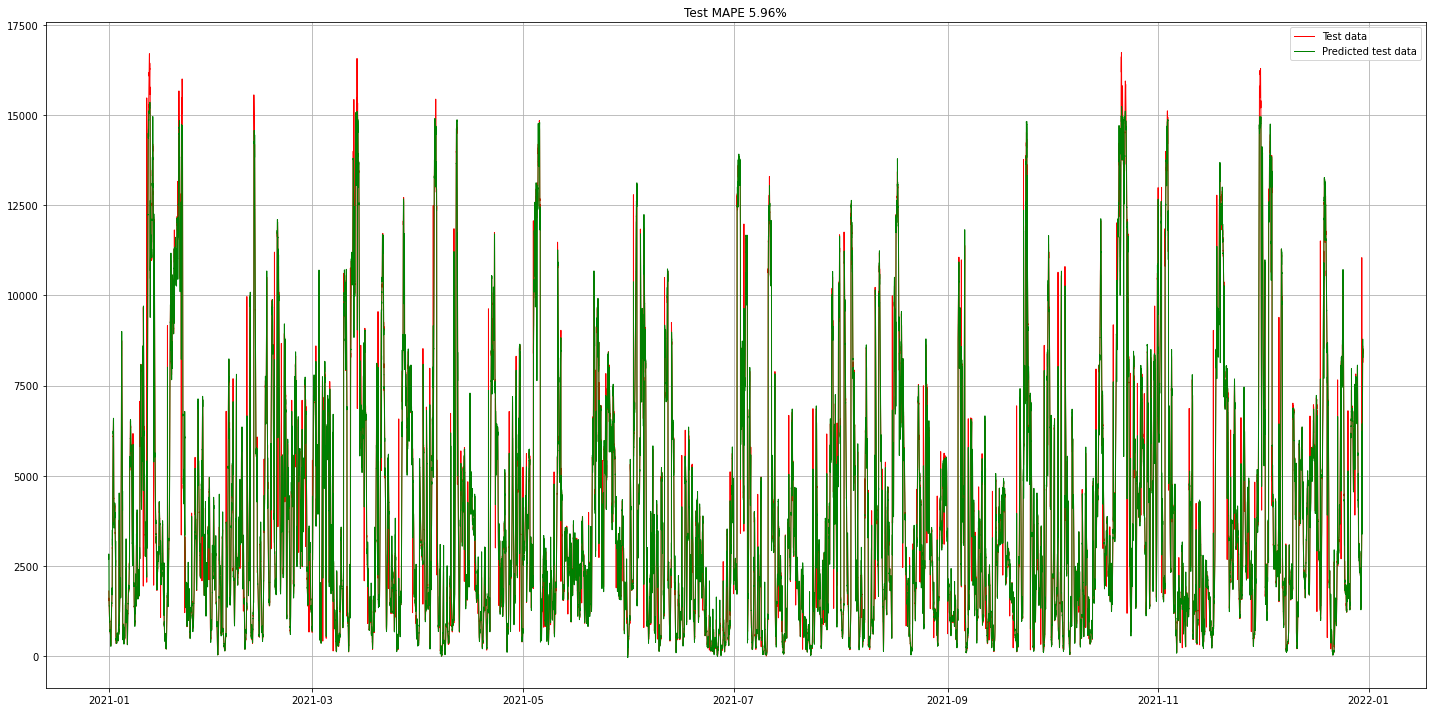

In [34]:
catboost_lag = CatBoostRegressor(iterations=100, learning_rate=0.7,
                          loss_function='RMSE', verbose=0)

catboost_lag.fit(X_train_lag_scaled, y_train_lag, verbose=0)

plotModelResults(catboost_lag, X_train_lag_scaled, y_train_lag, X_test_lag_scaled, y_test_lag)


CatBoost прогнозирует немного лучше, чем остальные модели, на тестовой выборке.

### Обогащение данных метео и экономической статистикой

Попробуем добавить метео и экономические данные в наш датасет. Для метео статистики воспользуюсь библиотекой meteostat, в ней есть ежедневные метеоданные по Германии, связанные с ветром:
- wspd - средняя скорость ветра
- wpgt - пиковые порывы ветра
- wdir - направление ветра (угол)
- snow - высота снега (для того, чтобы учесть, был ли снег и в каком количестве)

В этой библиотеке также необходимо выбрать, по какой метеостанции брать данные. Возьмем по метеостанции в Магдебурге, поскольку если посмотреть на карту, то именно в том регионе находится наибольшее скопление ветрогенераторов.

Исходный датасет ужмем также до дневных данных.

In [35]:
pd.DataFrame(wind.set_index('dt').resample('1d')['MW'].sum())

MW
dt                   
2011-01-01  518229.00
2011-01-02   83077.00
2011-01-03   73095.00
2011-01-04  376606.00
2011-01-05  216599.00
...               ...
2021-12-26  294921.35
2021-12-27  603998.08
2021-12-28  659450.45
2021-12-29  241640.15
2021-12-30  220220.08

[4017 rows x 1 columns]

In [36]:
wind_extra_data = pd.DataFrame(wind.set_index('dt').resample('1d')['MW'].sum())
wind_extra_data['year'] = wind_extra_data.index.year
wind_extra_data['month'] = wind_extra_data.index.month
wind_extra_data['weekday'] = wind_extra_data.index.weekday #Monday=0, Sunday=6
wind_extra_data['Weekend'] = ((wind_extra_data['weekday'] == 5) | (wind_extra_data['weekday'] == 6)).astype(int)

wind_extra_data.head()

MW  year  month  weekday  Weekend
dt                                                 
2011-01-01  518229.0  2011      1        5        1
2011-01-02   83077.0  2011      1        6        1
2011-01-03   73095.0  2011      1        0        0
2011-01-04  376606.0  2011      1        1        0
2011-01-05  216599.0  2011      1        2        0

In [37]:
start = datetime(2011, 1, 1)
end = datetime(2021, 12, 30)

weather_data = Daily('10361', start, end)
weather_data = weather_data.fetch()
weather_data = weather_data[['wspd', 'wpgt', 'wdir','snow']]
weather_data = weather_data.ffill()

weather_data.head()

wspd  wpgt   wdir   snow
time                                
2011-01-01  16.2  48.6  270.0  150.0
2011-01-02  10.4  34.2  286.0  120.0
2011-01-03   7.2  24.8  272.0  110.0
2011-01-04   5.8  18.0  189.0   90.0
2011-01-05  10.4  30.6  158.0   90.0

Убедимся, что заменили все пропуски:

In [38]:
weather_data.isnull().sum()

wspd    0
wpgt    0
wdir    0
snow    0
dtype: int64

In [39]:
weather_data.isna().sum()

wspd    0
wpgt    0
wdir    0
snow    0
dtype: int64

In [40]:
wind_res = pd.concat([wind_extra_data, weather_data], axis=1)
wind_res.head()

MW  year  month  weekday  Weekend  wspd  wpgt   wdir   snow
2011-01-01  518229.0  2011      1        5        1  16.2  48.6  270.0  150.0
2011-01-02   83077.0  2011      1        6        1  10.4  34.2  286.0  120.0
2011-01-03   73095.0  2011      1        0        0   7.2  24.8  272.0  110.0
2011-01-04  376606.0  2011      1        1        0   5.8  18.0  189.0   90.0
2011-01-05  216599.0  2011      1        2        0  10.4  30.6  158.0   90.0

Также удалось найти количество работников в сфере ветряной энергии и количество ветряков, но только годовые данные. Добавим это в датасет:

In [41]:
employees = pd.read_csv('data/employees-in-the-wind-industry.csv', sep=';')
employees.head()

Year  Employees
0  2002      46000
1  2003      48000
2  2004      61600
3  2005      65000
4  2006      70000

In [42]:
number_turbines = pd.read_csv('data/wind-turbines-in-germany.csv', sep=';')
number_turbines.head()

Year  Number of Turbines
0  2000                9359
1  2001               11438
2  2002               13759
3  2003               15387
4  2004               16543

In [43]:
wind_res['Employees'] = 0
wind_res['Turbines'] = 0

for i in wind_res['year'].unique():
    wind_res.loc[wind_res['year'] == i, 'Employees'] = employees[employees['Year'] == i]['Employees'].values[0]
    wind_res.loc[wind_res['year'] == i, 'Turbines'] = number_turbines[number_turbines['Year'] == i]['Number of Turbines'].values[0]
 

wind_res.head()
    

MW  year  month  weekday  Weekend  wspd  wpgt   wdir   snow  \
2011-01-01  518229.0  2011      1        5        1  16.2  48.6  270.0  150.0   
2011-01-02   83077.0  2011      1        6        1  10.4  34.2  286.0  120.0   
2011-01-03   73095.0  2011      1        0        0   7.2  24.8  272.0  110.0   
2011-01-04  376606.0  2011      1        1        0   5.8  18.0  189.0   90.0   
2011-01-05  216599.0  2011      1        2        0  10.4  30.6  158.0   90.0   

            Employees  Turbines  
2011-01-01     101080     22297  
2011-01-02     101080     22297  
2011-01-03     101080     22297  
2011-01-04     101080     22297  
2011-01-05     101080     22297

И, наконец, добавим лаги:

In [44]:
wind_res_lags = wind_res.copy()

for x in [1,12,24,48,72]:
    wind_res_lags[f'lag_{x}'] = wind_res.MW.shift(x).bfill()

wind_res_lags.head()

MW  year  month  weekday  Weekend  wspd  wpgt   wdir   snow  \
2011-01-01  518229.0  2011      1        5        1  16.2  48.6  270.0  150.0   
2011-01-02   83077.0  2011      1        6        1  10.4  34.2  286.0  120.0   
2011-01-03   73095.0  2011      1        0        0   7.2  24.8  272.0  110.0   
2011-01-04  376606.0  2011      1        1        0   5.8  18.0  189.0   90.0   
2011-01-05  216599.0  2011      1        2        0  10.4  30.6  158.0   90.0   

            Employees  Turbines     lag_1    lag_12    lag_24    lag_48  \
2011-01-01     101080     22297  518229.0  518229.0  518229.0  518229.0   
2011-01-02     101080     22297  518229.0  518229.0  518229.0  518229.0   
2011-01-03     101080     22297   83077.0  518229.0  518229.0  518229.0   
2011-01-04     101080     22297   73095.0  518229.0  518229.0  518229.0   
2011-01-05     101080     22297  376606.0  518229.0  518229.0  518229.0   

              lag_72  
2011-01-01  518229.0  
2011-01-02  518229.0  
2011-01-03  518229.0  
2011-01-04  518229.0  
2011-01-05  518229.0

In [45]:
train_res = pd.DataFrame(wind_res_lags.loc[:'2020-12-31 23:45:00'])
test_res = pd.DataFrame(wind_res_lags.loc['2021-01-01 00:00:00':])
print('Train shape: ',train_res.shape,'. Test shape: ',test_res.shape)

Train shape:  (3653, 16) . Test shape:  (364, 16)


In [46]:
X_train_res = train_res.drop('MW',1)
X_test_res = test_res.drop('MW',1)
y_train_res = train_res['MW']
y_test_res = test_res['MW']

print('X Train shape: ',X_train_res.shape,'. X Test shape: ',X_test_res.shape)
print('Y Train shape: ',y_train_res.shape,'. Y Test shape: ',y_test_res.shape)

X Train shape:  (3653, 15) . X Test shape:  (364, 15)
Y Train shape:  (3653,) . Y Test shape:  (364,)


In [47]:
scaler_res = StandardScaler()

X_train_res_scaled = scaler_res.fit_transform(X_train_res)
X_test_res_scaled = scaler_res.transform(X_test_res)

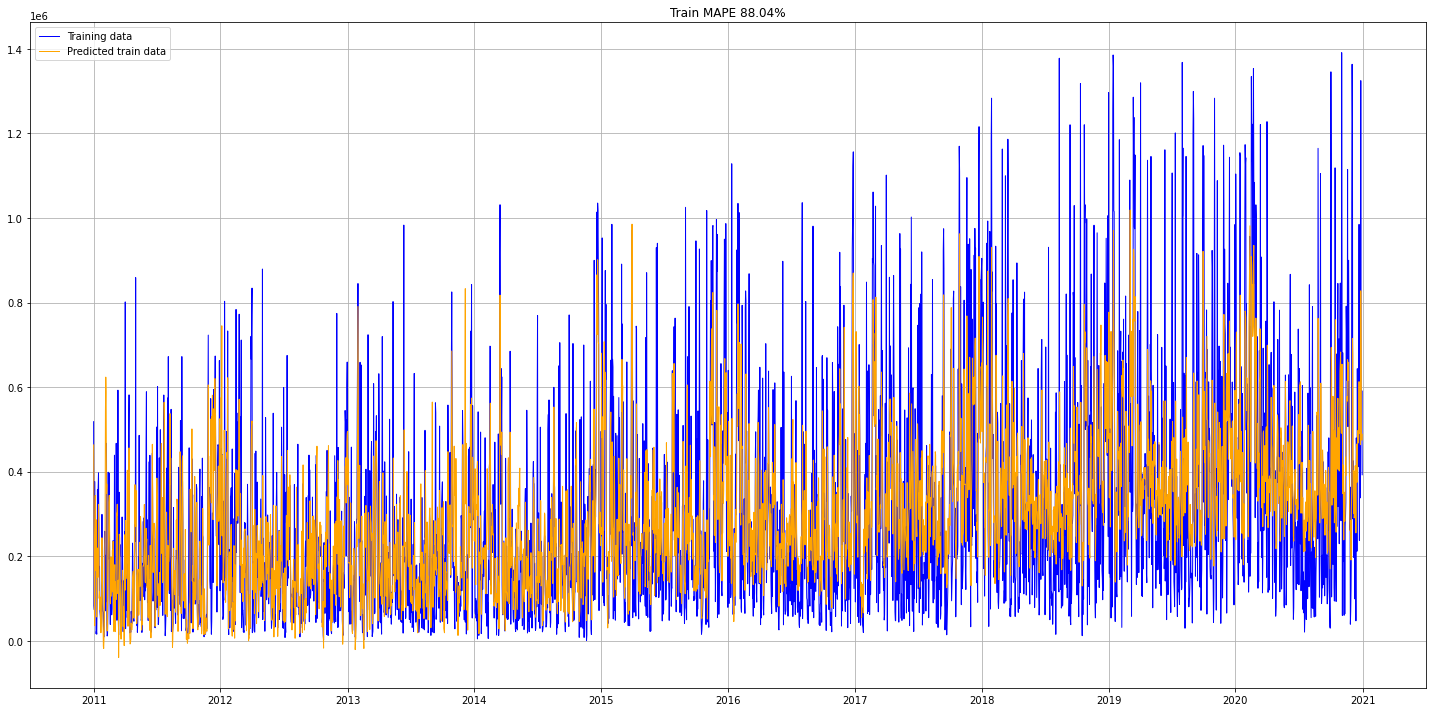

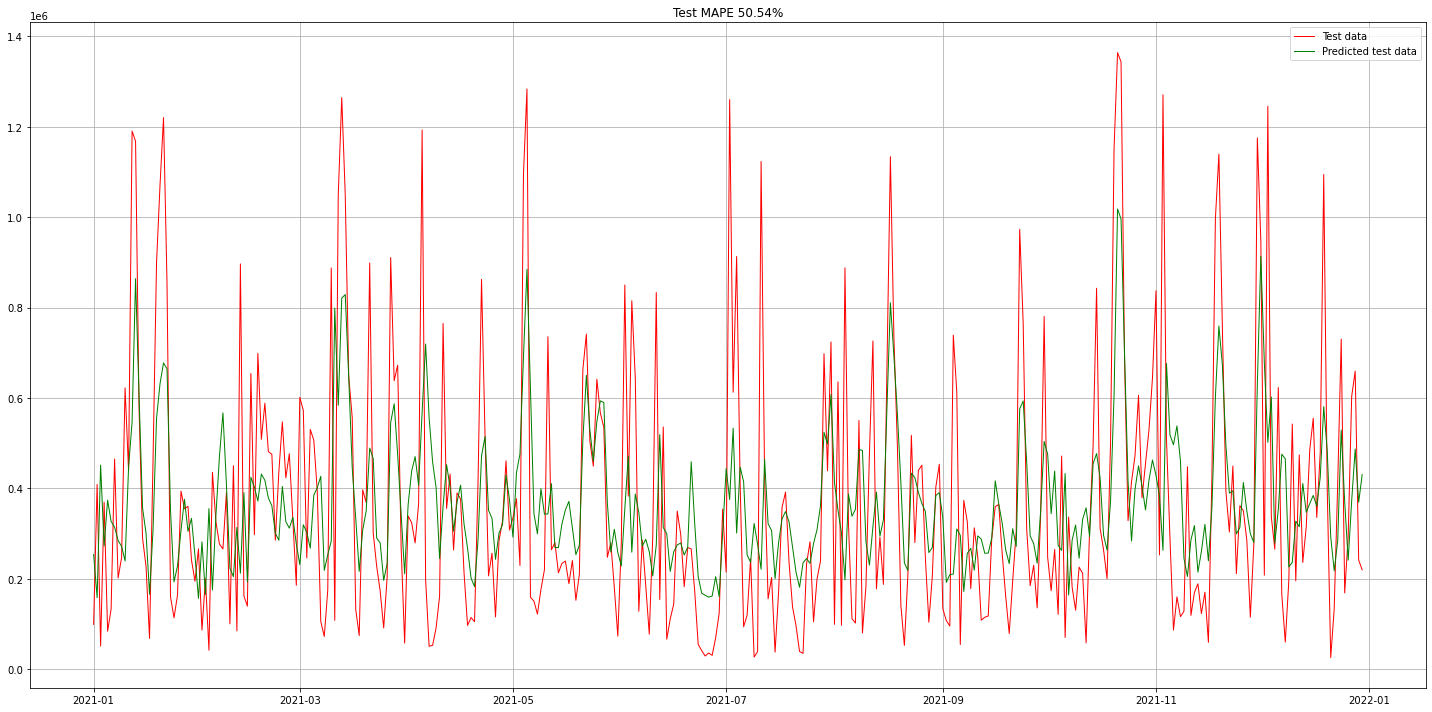

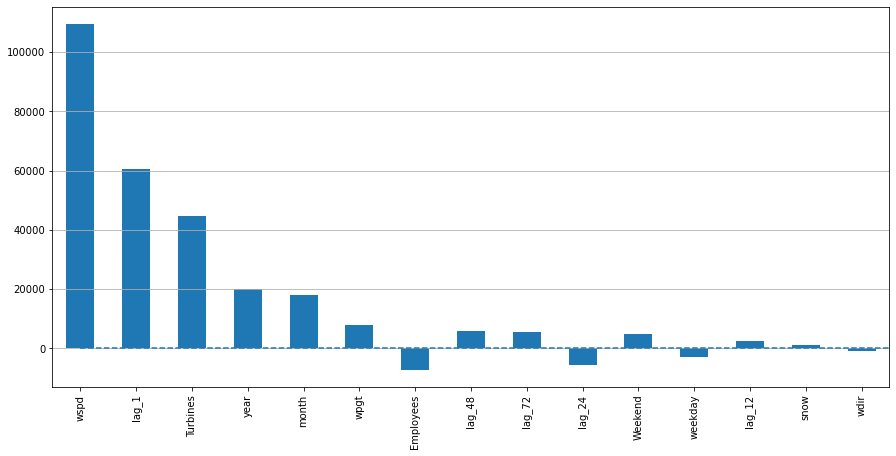

In [48]:
lr_lag = LinearRegression()
lr_lag.fit(X_train_res_scaled, y_train_res)

plotModelResults(lr_lag, X_train_res_scaled, y_train_res, X_test_res_scaled, y_test_res)

plotCoefficients(lr_lag,X_train_res)

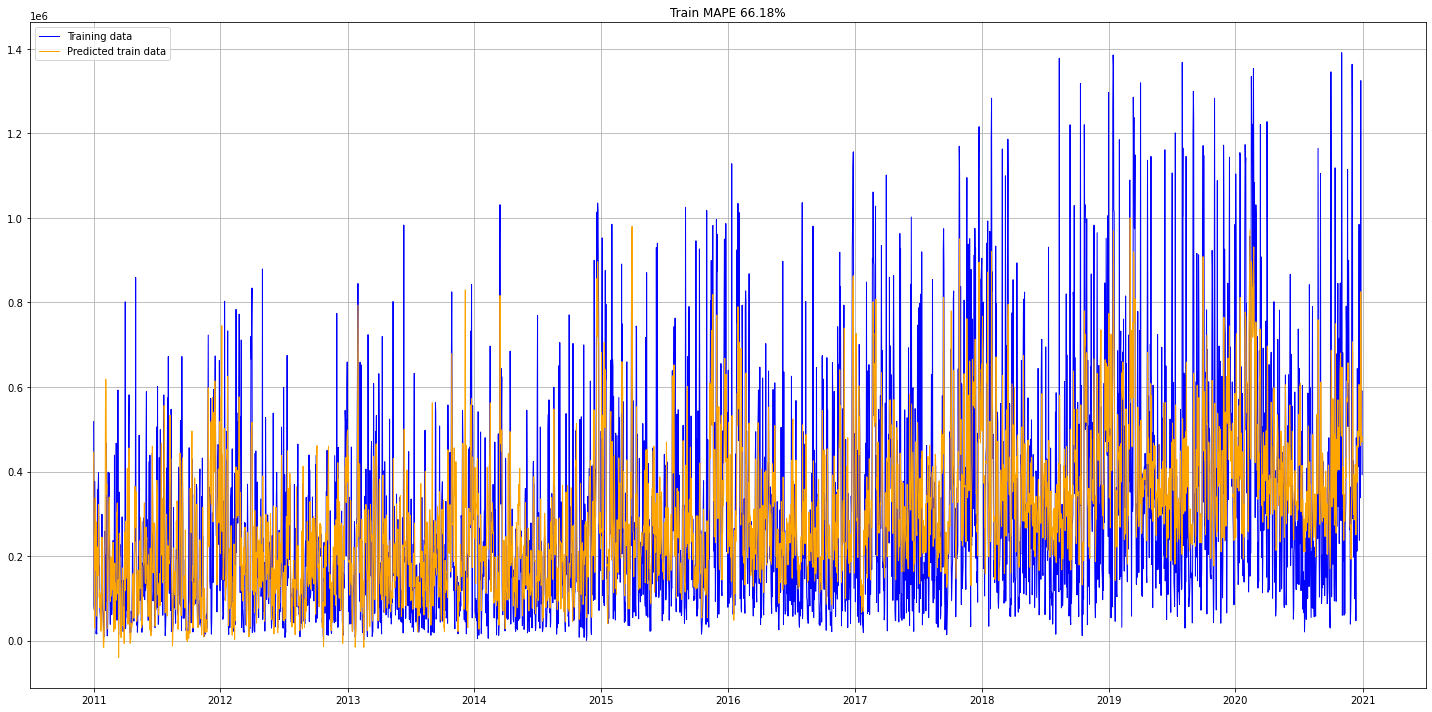

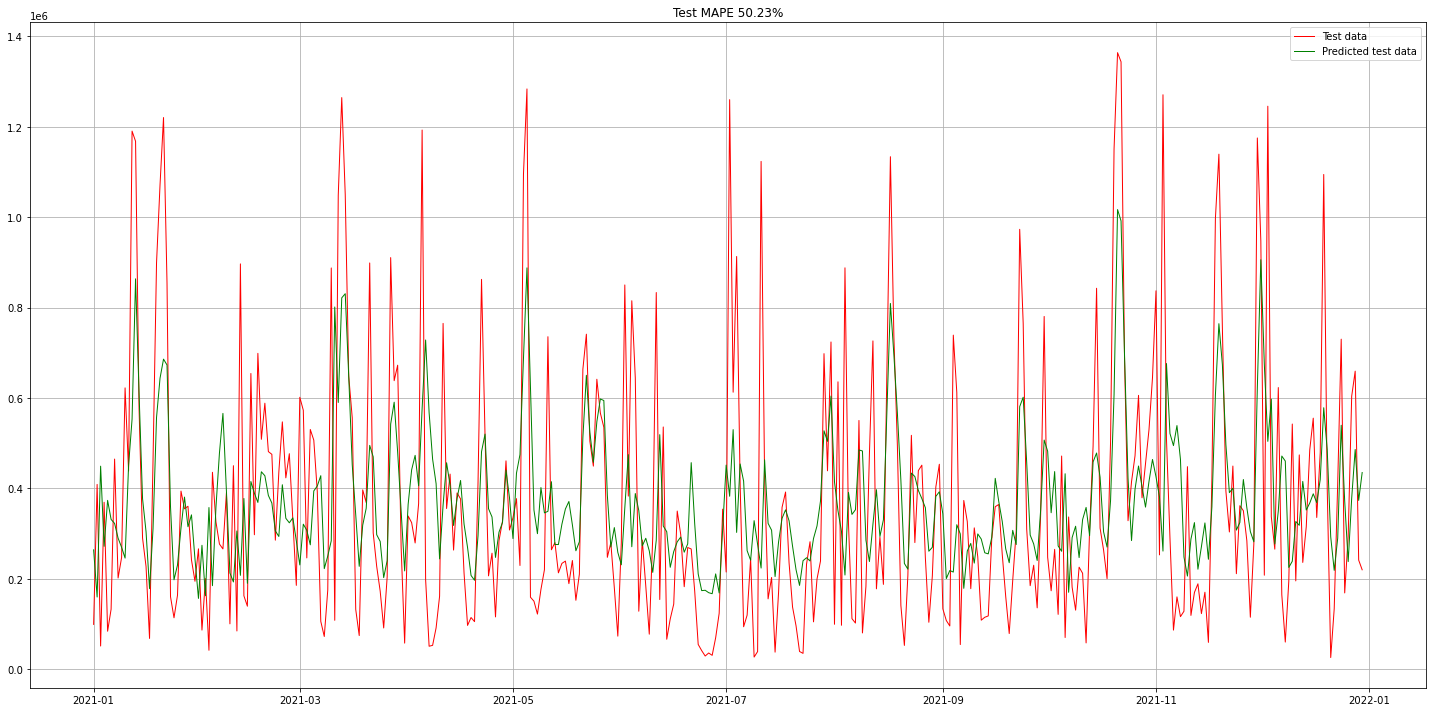

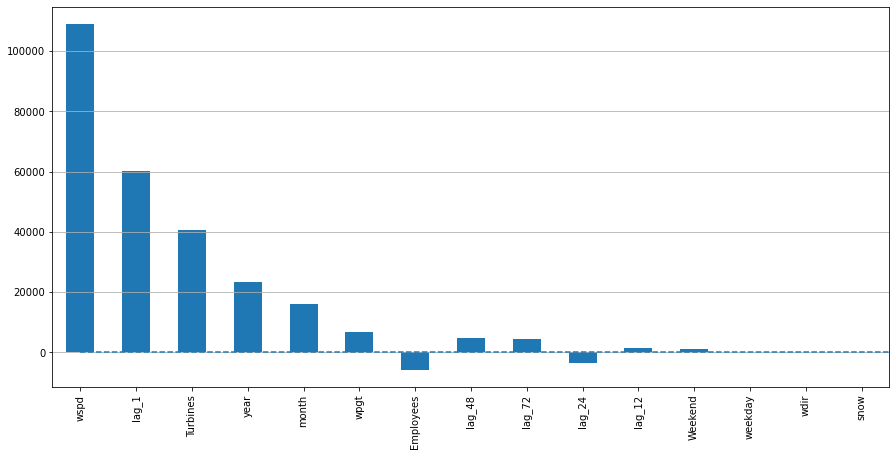

In [49]:
tscv = TimeSeriesSplit(n_splits=5)

lasso_res = LassoCV(cv=tscv, eps=0.01)
lasso_res.fit(X_train_res_scaled, y_train_res)

plotModelResults(lasso_res, X_train_res_scaled, y_train_res, X_test_res_scaled, y_test_res)

plotCoefficients(lasso_res,X_train_res)

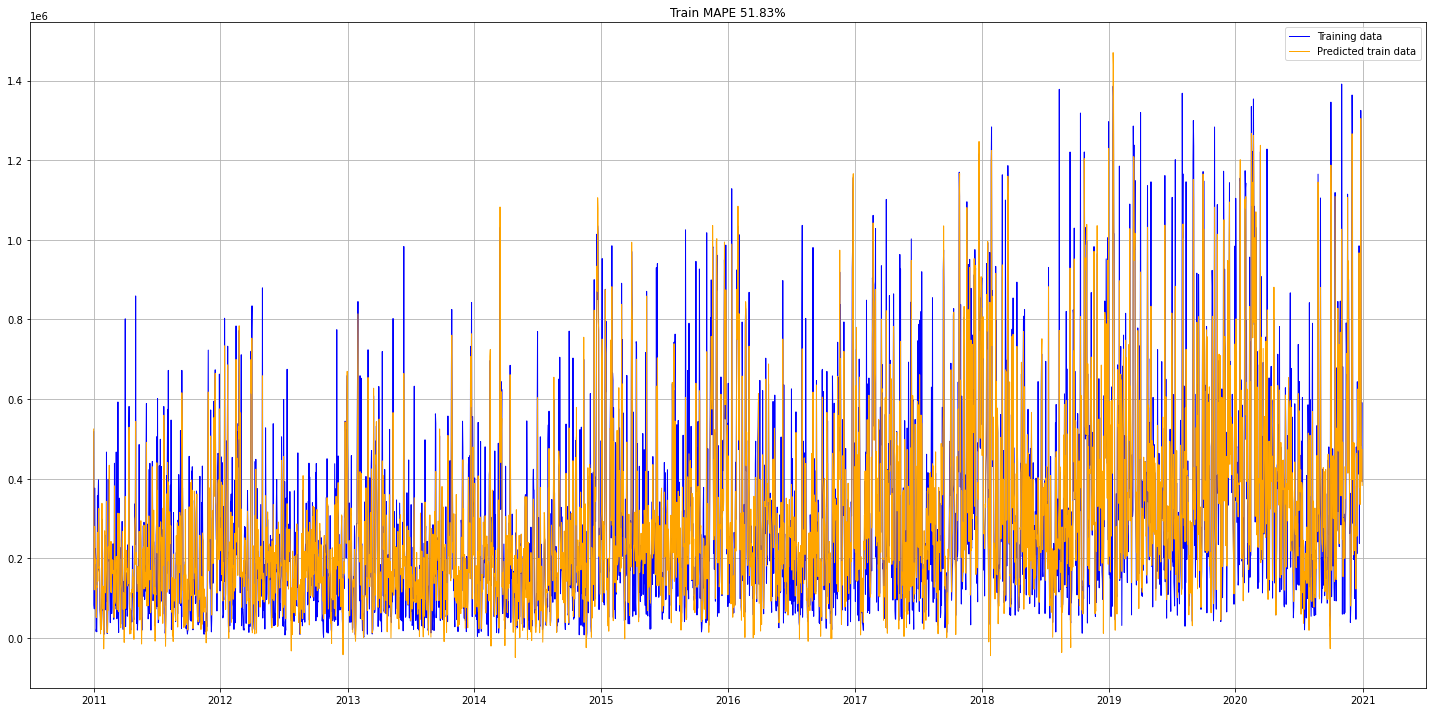

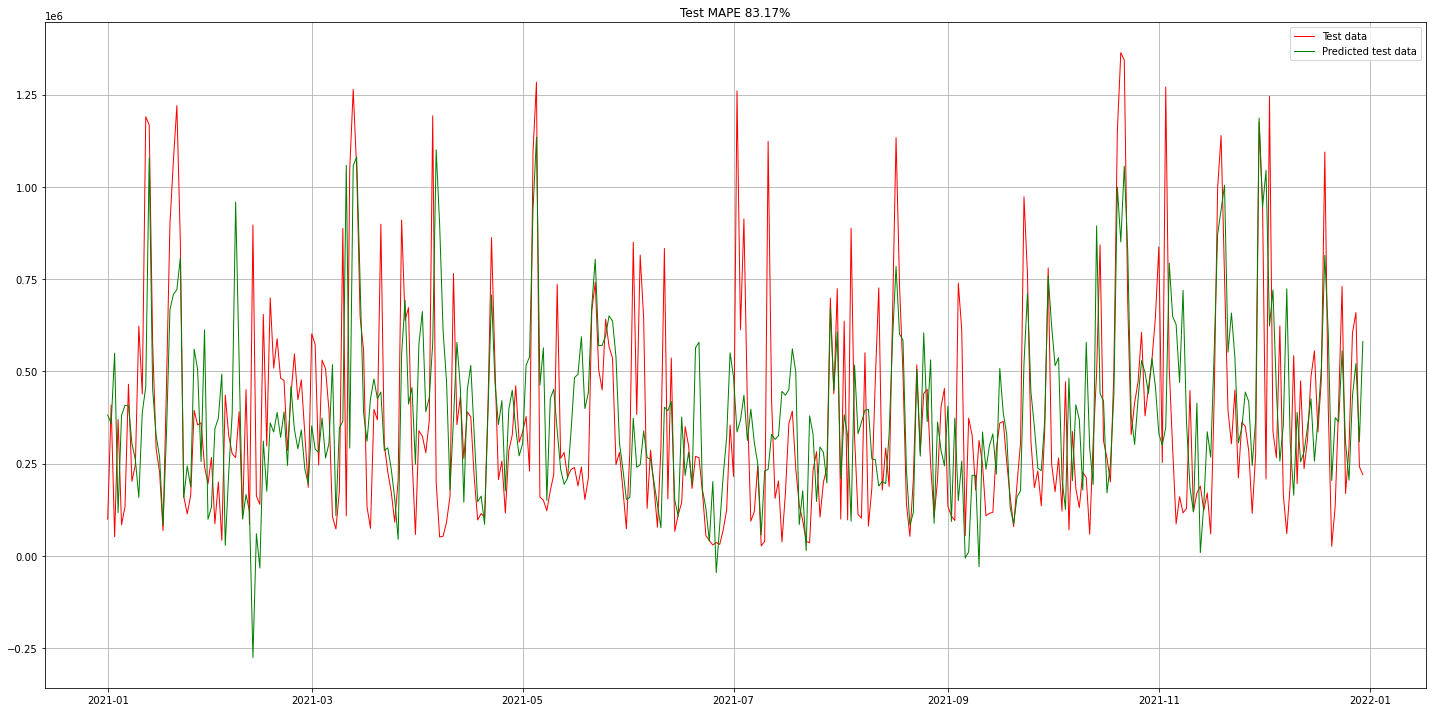

In [50]:
catboost_res = CatBoostRegressor(iterations=100, learning_rate=0.7,
                          loss_function='RMSE', verbose=0)

catboost_res.fit(X_train_res_scaled, y_train_res, verbose=0)

plotModelResults(catboost_res, X_train_res_scaled, y_train_res, X_test_res_scaled, y_test_res)

Данный подход по качеству хуже, чем предыдущий, но если судить по графикам, то модели все равно могут прогнозировать общее поведение временного ряда. Также интересно, что на модели оказывают наибольшее влияние данные по средней скорости ветра, количеству турбин, лаг 1, что вполне подтверждает наши первоначальные предположения.